# <center>Enron Dataset Network Analysis

# Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import re
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option("display.max_column", None)
pd.set_option("display.max_row", 50)

# EDA

In [2]:
df = pd.read_csv("data/emails.csv")

In [3]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
df.shape

(517401, 2)

As we can see our dataset has more than **half a million** rows

In [5]:
df.message[0]

"Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n "

We can also observe that our text split with **"\n"** 

# Data cleaning

So Next, we are going to create functions for:

- Spliting the emails 
- Extract meaningful text from them.
- Cleaning the extracted text

In [6]:
def split_text(text, match):
    text = re.sub(r"\n\t", "", text)
    return re.split(match, text)

We then store the new split text into a new column

In [7]:
df["clean_message"] = df.message.apply(lambda x : split_text(x, "\n"))
df.head()

,file,message,clean_message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,[Message-ID: <18782981.1075855378110.JavaMail....
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,[Message-ID: <15464986.1075855378456.JavaMail....
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,[Message-ID: <24216240.1075855687451.JavaMail....
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,[Message-ID: <13505866.1075863688222.JavaMail....
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,[Message-ID: <30922949.1075863688243.JavaMail....


In [8]:
df.clean_message[0]

['Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>',
 'Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)',
 'From: phillip.allen@enron.com',
 'To: tim.belden@enron.com',
 'Subject: ',
 'Mime-Version: 1.0',
 'Content-Type: text/plain; charset=us-ascii',
 'Content-Transfer-Encoding: 7bit',
 'X-From: Phillip K Allen',
 'X-To: Tim Belden <Tim Belden/Enron@EnronXGate>',
 'X-cc: ',
 'X-bcc: ',
 "X-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail",
 'X-Origin: Allen-P',
 'X-FileName: pallen (Non-Privileged).pst',
 '',
 'Here is our forecast',
 '',
 ' ']

We can see out email is now split into a list containing multiple elements, we will go ahead and extract the meaningful text from these lists, such as "sender email", "recipient email" ... etc

In [9]:
def extract_body(text, substr):	
    result = re.split(substr, text)[-1]
    result = re.sub(r"([\n-])", "", result)
    return result

In [10]:
df["date"] = df.clean_message.apply(lambda x : x[1])
df["sender_email"] = df.clean_message.apply(lambda x : x[2])
df["recipient_email"] = df.clean_message.apply(lambda x : x[3])
df["subject"] = df.clean_message.apply(lambda x : x[4])
df["cc"] = df.clean_message.apply(lambda x : x[5])
df["bcc"] = df.clean_message.apply(lambda x : x[9])
df["body"] = df.message.apply(lambda x : extract_body(x, r"X-FileName: [\w]*[\s]*[(Non\-Privileged).pst]*[\w-]*[.nsf]*").strip())

In [11]:
df.head(3)

,file,message,clean_message,date,sender_email,recipient_email,subject,cc,bcc,body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,[Message-ID: <18782981.1075855378110.JavaMail....,"Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)",From: phillip.allen@enron.com,To: tim.belden@enron.com,Subject:,Mime-Version: 1.0,X-To: Tim Belden <Tim Belden/Enron@EnronXGate>,Here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,[Message-ID: <15464986.1075855378456.JavaMail....,"Date: Fri, 4 May 2001 13:51:00 -0700 (PDT)",From: phillip.allen@enron.com,To: john.lavorato@enron.com,Subject: Re:,Mime-Version: 1.0,X-To: John J Lavorato <John J Lavorato/ENRON@e...,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,[Message-ID: <24216240.1075855687451.JavaMail....,"Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",From: phillip.allen@enron.com,To: leah.arsdall@enron.com,Subject: Re: test,Mime-Version: 1.0,X-To: Leah Van Arsdall,test successful. way to go!!!


A lot of work, but we still aren't finished with the data cleaning process

The sender and recepient emails still need some cleaning, like removing the "From: " and "To: ", as well as extracting the subject.

In [12]:
def extract_emails(text, substr):
    result = re.findall("[^\s]+@[\w]+.[\w]+", str(text))
    if substr not in text:
        result = ""
    return result

def extract_subject(text):

    list_of_words = re.split("\s", text)
    words_to_drop = ["Subject:","re:","Re:","RE:","fw:","Fw:", "FW:"]

    desired_words = []
    for word in list_of_words:
        if word not in words_to_drop:
            desired_words.append(word)

    r = re.compile("[\w]{3,}")
    final_list = list(filter(r.match, desired_words))

    return final_list

In [13]:
#Trim and clean date
df.loc[:,"date"] = df.loc[:,"date"].apply(lambda x : x[10:22])

#- Trim and clean sender and recipient email
df.loc[:,"sender_email"] = df.loc[:,"sender_email"].apply(lambda x : extract_emails(x, "From: "))
df.loc[:,"recipient_email"] = df.loc[:,"recipient_email"].apply(lambda x : extract_emails(x, "To: "))
df.loc[:,"cc"] = df.loc[:,"cc"].apply(lambda x : extract_emails(x, "Cc: "))
df.loc[:,"bcc"] = df.loc[:,"bcc"].apply(lambda x : extract_emails(x, "Bcc: "))

#- Trim and clean subject
df.loc[:,"subject"] = df.loc[:,"subject"].apply(lambda x : extract_subject(x))

We also need to store all recepients emails -- **ie: the recepients, the CCs and BCCs** -- in a column, as well their number 

In [14]:
df["all_recipient_emails"] = df.apply(lambda x : list(x["recipient_email"]) + list(x["cc"]) + list(x["bcc"]), axis = 1)

df["num_recipient"] = df.recipient_email.apply(lambda x : len(x)) + df.cc.apply(lambda x : len(x)) + \
                                df.bcc.apply(lambda x : len(x))

In [74]:
#Checking for emails without recepients
df[df["num_recipient"]==0].shape

(0, 17)

We have **21767 emails** that don't have a receptient, these are probably drafts that were never sent, so we'll not take them into consideration

In [73]:
df=df[df["num_recipient"]!=0]

To further deepen our analysis we'll also extract information about the entity (corporation) that these mails belong to.

In [15]:
def extract_entity(text):
    string = ""
    for i in text:
        string = string + " " + i

    list_of_emails = list(re.findall(r"@[\w]+", string))
    result = []
    for item in list_of_emails:
        result.append(item[1:])

    return set(result)

In [16]:
#- extract sender and recipient entity info
df["sender_entity"]    = df.loc[:,"sender_email"].apply(lambda x : extract_entity(x))
df["recipient_entity_to"] = df.loc[:,"recipient_email"].apply(lambda x : extract_entity(x))
df["recipient_entity_cc"] = df.loc[:,"cc" ].apply(lambda x : extract_entity(x))
df["recipient_entity_bcc"] = df.loc[:,"bcc"].apply(lambda x : extract_entity(x))

df["all_recipient_entities"] = df.apply(lambda x : \
                                                 x["recipient_entity_to" ] | \
                                                 x["recipient_entity_cc" ] | \
                                                 x["recipient_entity_bcc"], axis = 1)

df["sender_entity"] = df.sender_entity.apply(lambda x : list(x))

df["all_recipient_entities"] = df.all_recipient_entities.apply(lambda x : list(x))

Since `all_recipient_emails` contain multiple emails, to construct our network **graph** we must split them into multiple rows

In [29]:
def split_into_rows(df_col1, df_col2):
    result_df = pd.DataFrame({ "send" : np.repeat(df_col1.values, df_col2.str.len()),"receive": list(chain.from_iterable(df_col2))})
    result_df.send = result_df.send.apply(lambda x : x[0] if len(x) >0 else '')
    return result_df

In [30]:
df_emails = split_into_rows(df.sender_email, df.all_recipient_emails)

We'll also do the same thing for entites

In [32]:
df_entities = split_into_rows(df.sender_entity, df.all_recipient_entities)

# Visualise

Now we'll only visualise part of the network (graph), due to the large size of it.

So we'll take a random sample of 200 emails, an try to visualize the network

In [118]:
df_sample = df.sample(n = 200, random_state = 0)

In [119]:
#splitting

df_sample_emails = split_into_rows(df_sample.sender_email, df_sample.all_recipient_emails)
df_sample_entities = split_into_rows(df_sample.sender_entity, df_sample.all_recipient_entities)

First, the **emails graph**

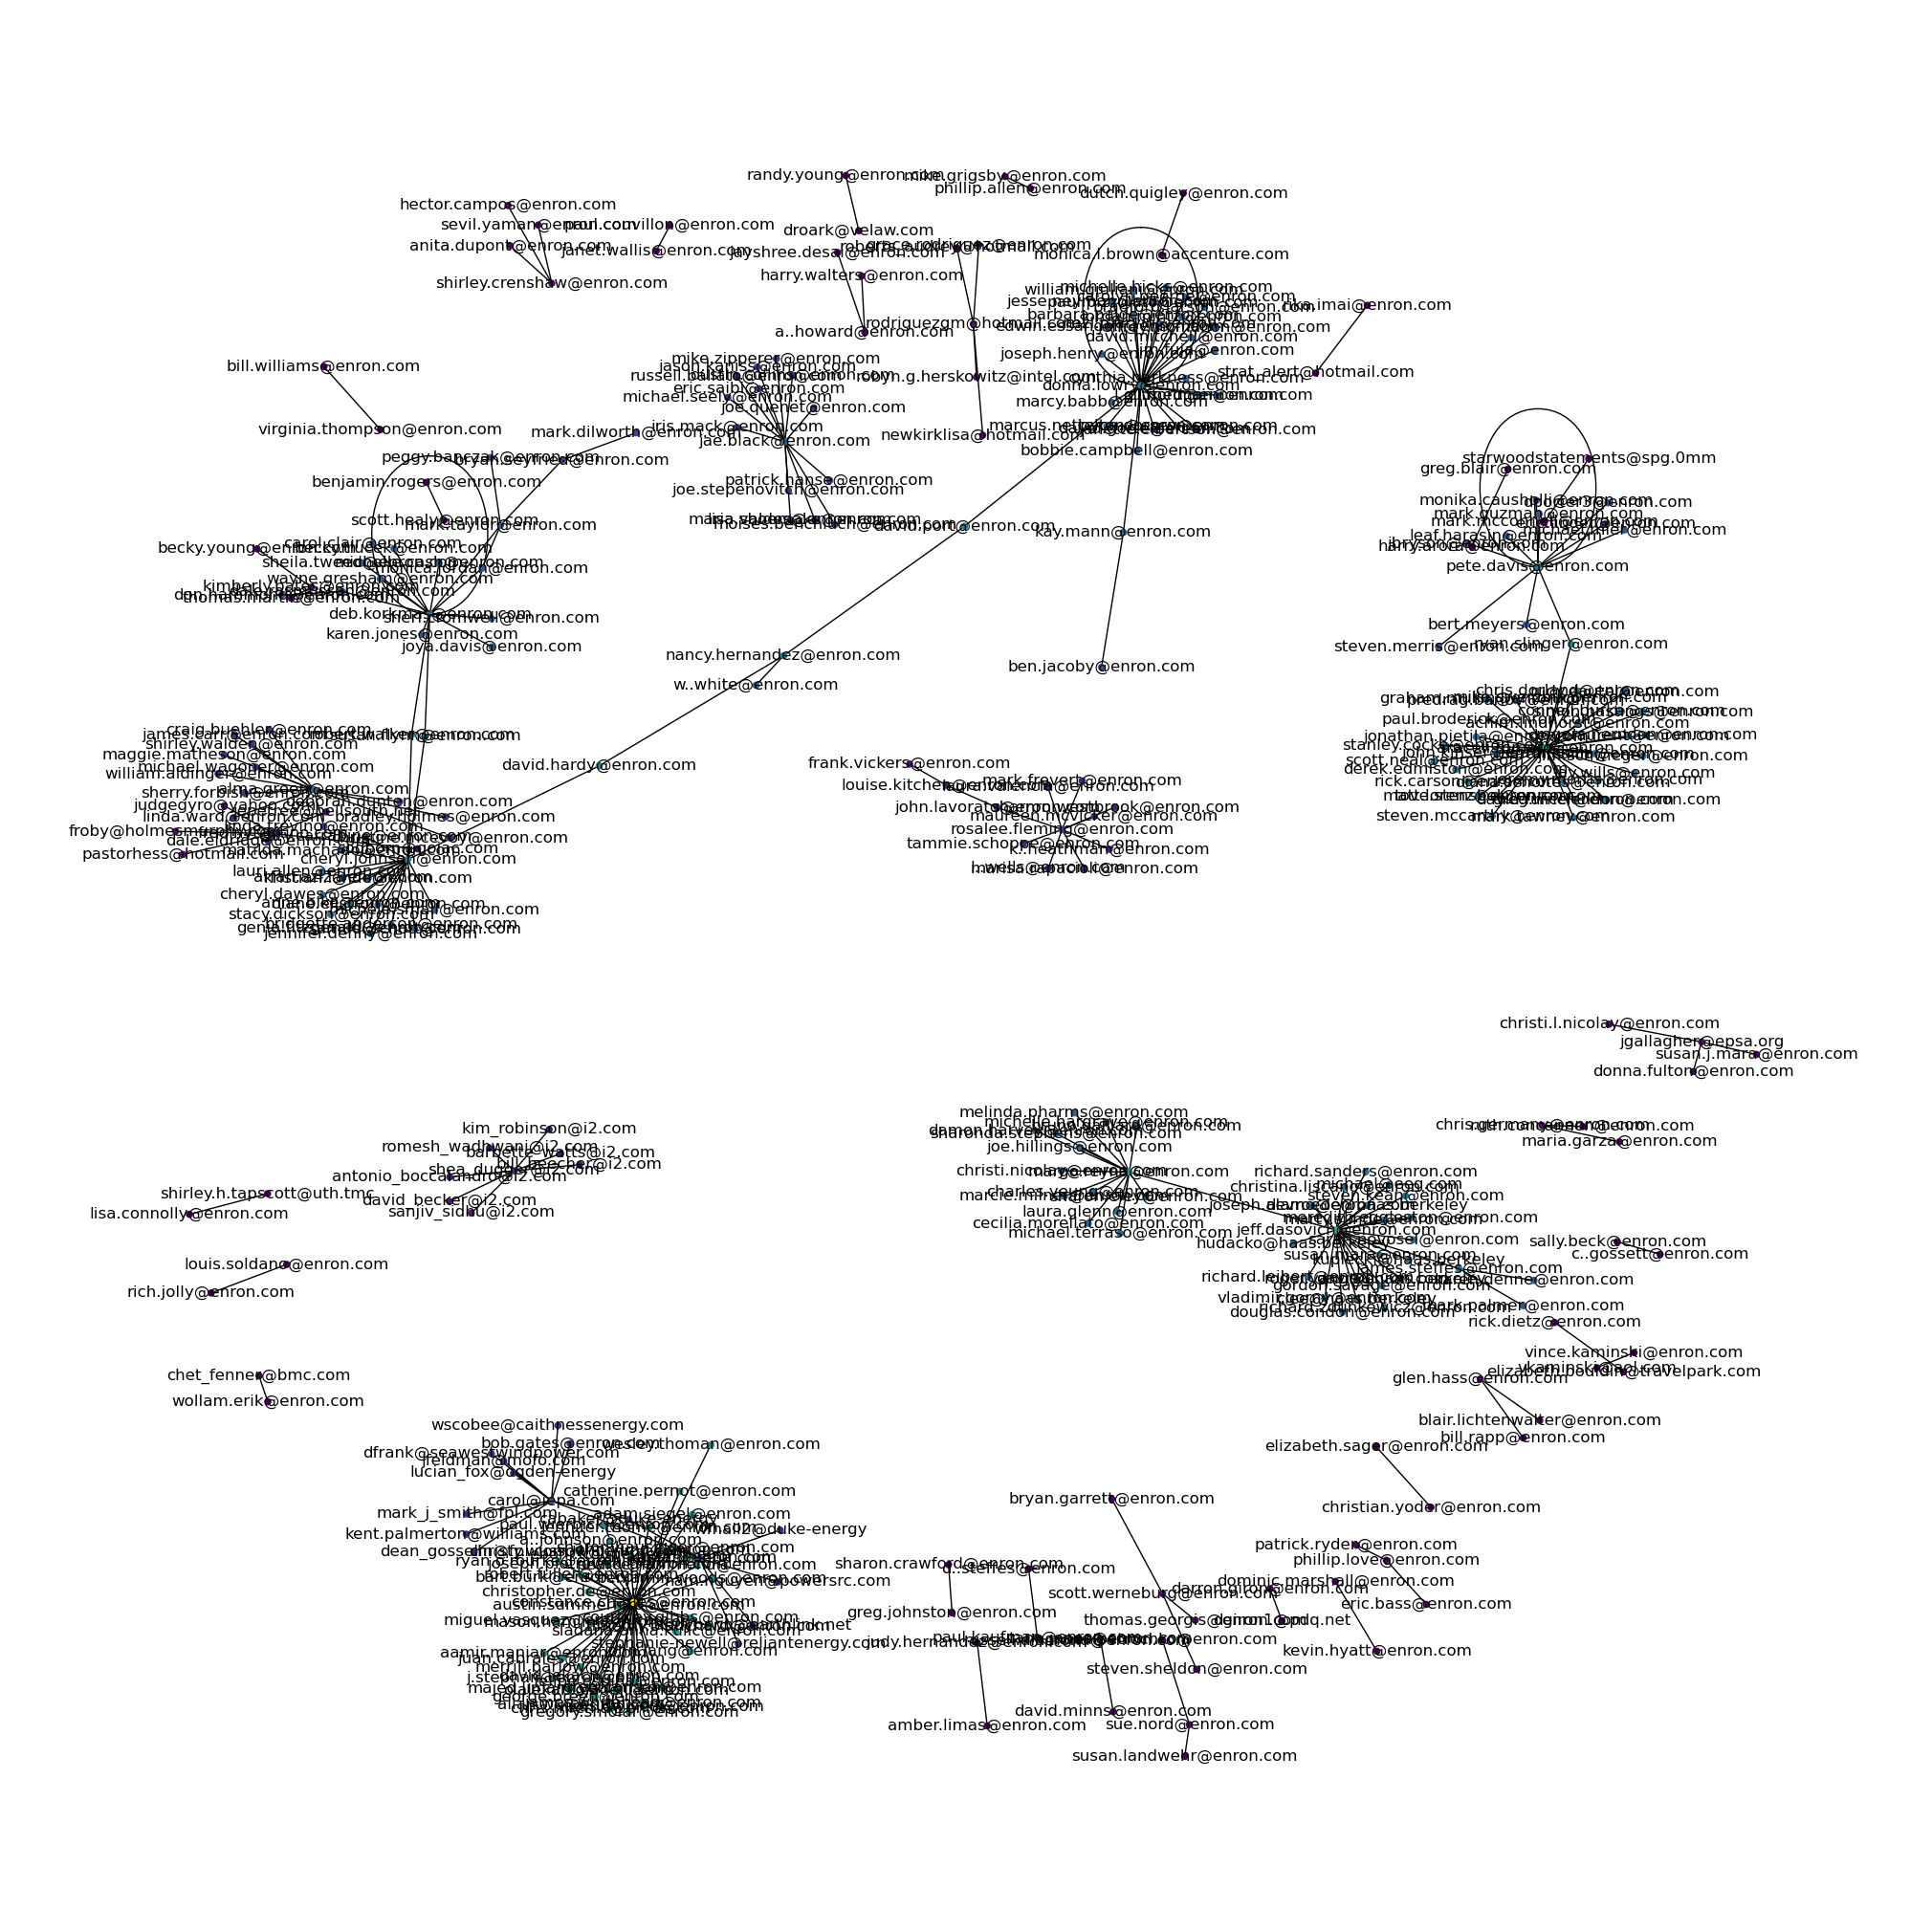

In [123]:
G1 = nx.from_pandas_edgelist(df_sample_emails.sample(round(0.1*len(df_sample_emails)), random_state = 0), "send", "receive")

closeness_G1 = nx.closeness_centrality(G1)
closeness_G1 = list(closeness_G1.values())

plt.figure(figsize = (20,20))

pos1 = nx.spring_layout(G1, k=.1)
nx.draw(G1, pos1, node_size = 20, node_color = closeness_G1, with_labels = True)
plt.show()

And now for **entities (corporations)**

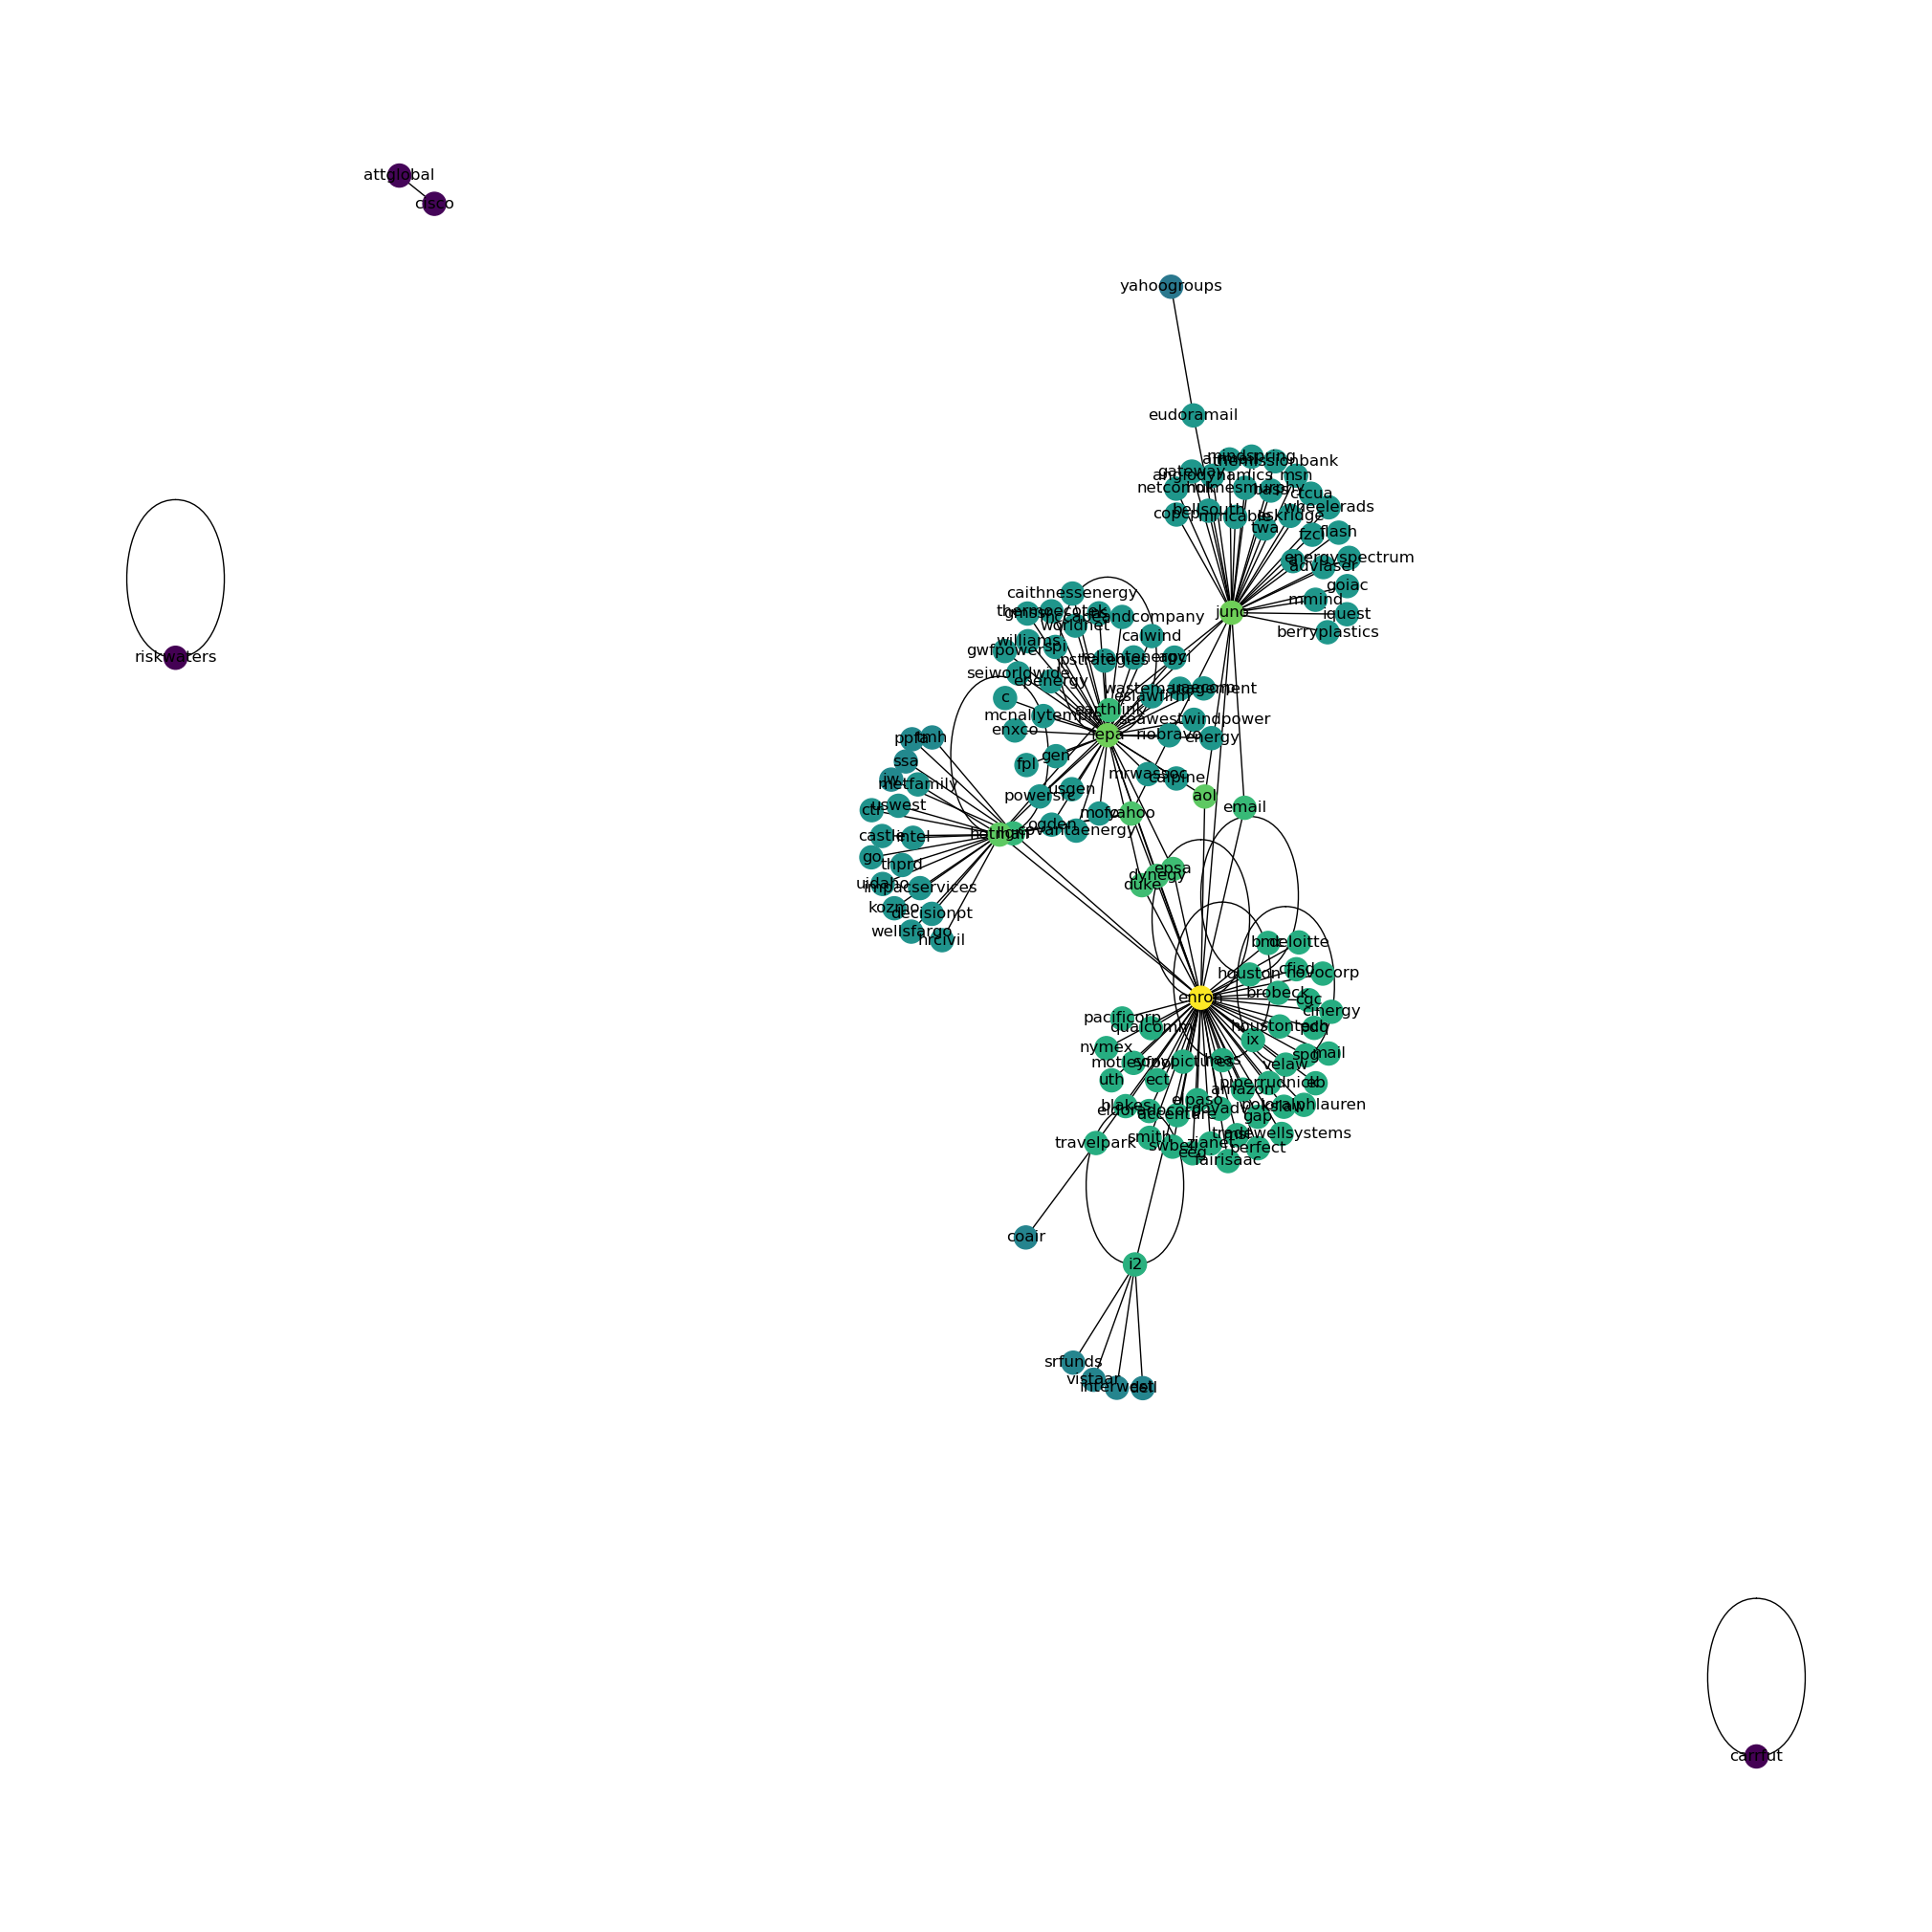

In [125]:
G2 = nx.from_pandas_edgelist(df_sample_entities, "send", "receive")

closeness_G2 = nx.closeness_centrality(G2)
closeness_G2 = list(closeness_G2.values())

plt.figure(figsize = (20,20))
pos2 = nx.spring_layout(G2, k=.1)
nx.draw(G2, pos2, node_size = 300, node_color = closeness_G2,with_labels = True)
plt.show()

### Further work

There exists multiple variants of the **Enron** Dataset, some containing more information about the emails, such as attachement files (pictures, videos, ..etc).

And also a **Person of Interest** tag, which inidcates individuals who were implied in the scandal and therefore called into the courtroom. 

We can train a graph model on a propoportion of the graph, and use it to identify those potential POI. and even identify some suspicious emails sent from those POIs